Loading dataset...
Combined dataset shape: (3672151, 7)

Preprocessing data...
Removed 0 duplicate rows. Shape after: (3672151, 7)

Overall Class Distribution:
Label
Normal    3372743
Attack     299408
Name: count, dtype: int64

Training model...

Training set shape: (2937720, 11) (80.00% of total)
Test set shape: (734431, 11) (20.00% of total)

Training set class distribution:
Label
Normal    2698194
Attack     239526
Name: count, dtype: int64

Test set class distribution:
Label
Normal    674549
Attack     59882
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 239526, number of negative: 2698194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 2937720, number of used features: 11
[LightGBM] [Info] [binary:

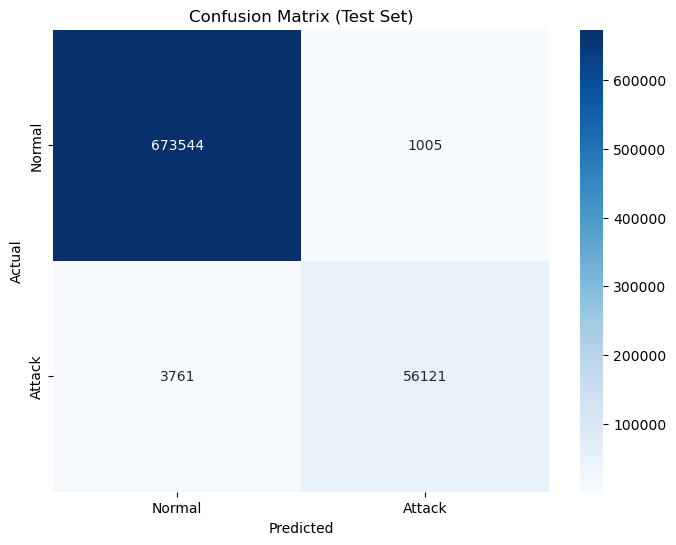

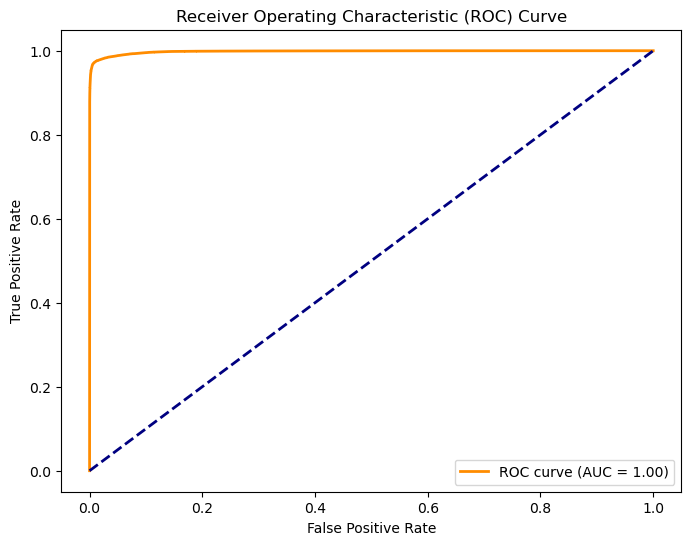

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the dataset directory
directory = "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training"

# Step 2: Load and merge all CSV files
def load_and_merge_files(dir_path):
    all_dfs = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(dir_path, filename)
            try:
                df = pd.read_csv(file_path)
                df['File'] = filename  # Add file identifier for reference
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    if not all_dfs:
        raise ValueError("No CSV files found or all files failed to load.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

# Step 3: Preprocess the data
def preprocess_data(df):
    # Handle missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    # Numerical columns
    num_cols = ['Timestamp', 'DLC']
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
    
    # Categorical columns
    cat_cols = ['Arbitration_ID', 'Data', 'Class']
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    
    # Remove duplicates
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - df.shape[0]} duplicate rows. Shape after: {df.shape}")
    
    # Parse Data field into individual bytes
    def parse_data(data_str):
        try:
            bytes_list = data_str.strip().split()
            bytes_int = [int(b, 16) if b else 0 for b in bytes_list]
            while len(bytes_int) < 8:
                bytes_int.append(0)
            return bytes_int[:8]
        except:
            return [0] * 8
    
    data_bytes = df['Data'].apply(parse_data)
    data_bytes_df = pd.DataFrame(data_bytes.tolist(), columns=[f'Byte_{i+1}' for i in range(8)], index=df.index)
    df = pd.concat([df, data_bytes_df], axis=1)
    df.drop('Data', axis=1, inplace=True)
    
    # Feature engineering: Time differences
    df.sort_values('Timestamp', inplace=True)
    df['Time_Diff'] = df['Timestamp'].diff().fillna(0)
    
    # Encode categorical features
    le_arb = LabelEncoder()
    df['Arbitration_ID_Encoded'] = le_arb.fit_transform(df['Arbitration_ID'])
    
    # Binary classification: Normal (0) vs Attack (1)
    df['Label'] = df['Class'].apply(lambda x: 0 if x.lower() == 'normal' else 1)
    
    # Drop unnecessary columns
    df.drop(['Timestamp', 'Arbitration_ID', 'Class', 'SubClass', 'File'], axis=1, errors='ignore', inplace=True)
    
    return df

# Step 4: Train and evaluate the model
def train_model(X, y):
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Print dataset info
    total_samples = len(X)
    print(f"\nTraining set shape: {X_train.shape} ({len(X_train)/total_samples*100:.2f}% of total)")
    print(f"Test set shape: {X_test.shape} ({len(X_test)/total_samples*100:.2f}% of total)")
    
    # Class distribution
    print("\nTraining set class distribution:")
    print(pd.Series(y_train).value_counts().rename({0: 'Normal', 1: 'Attack'}))
    print("\nTest set class distribution:")
    print(pd.Series(y_test).value_counts().rename({0: 'Normal', 1: 'Attack'}))
    
    # Train LightGBM
    model = LGBMClassifier(n_estimators=100, random_state=42, objective='binary', metric='binary_logloss')
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy
    print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    
    # Classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Attack']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    
    # ROC Curve
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return model

# Main execution
if __name__ == "__main__":
    try:
        print("Loading dataset...")
        df = load_and_merge_files(directory)
        
        print("\nPreprocessing data...")
        df_processed = preprocess_data(df)
        
        print("\nOverall Class Distribution:")
        print(df_processed['Label'].value_counts().rename({0: 'Normal', 1: 'Attack'}))
        
        X = df_processed.drop('Label', axis=1)
        y = df_processed['Label']
        
        print("\nTraining model...")
        ids_model = train_model(X, y)
        
    except Exception as e:
        print(f"An error occurred: {e}")

Loading dataset...
Combined dataset shape: (3672151, 7)

Preprocessing data...
Removed 0 duplicate rows. Shape after: (3672151, 7)

Class distribution in dataset:
SubClass
Normal      3372743
Flooding     154180
Fuzzing       89879
Replay        47593
Spoofing       7756
Name: count, dtype: int64

Overall Class Distribution:
Label
Normal      3372743
Flooding     154180
Fuzzing       89879
Replay        47593
Spoofing       7756
Name: count, dtype: int64

Training model...

Training set shape: (2937720, 11) (80.00% of total)
Test set shape: (734431, 11) (20.00% of total)

Training set class distribution:
Label
Normal      2698194
Flooding     123344
Fuzzing       71903
Replay        38074
Spoofing       6205
Name: count, dtype: int64

Test set class distribution:
Label
Normal      674549
Flooding     30836
Fuzzing      17976
Replay        9519
Spoofing      1551
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032503 seco

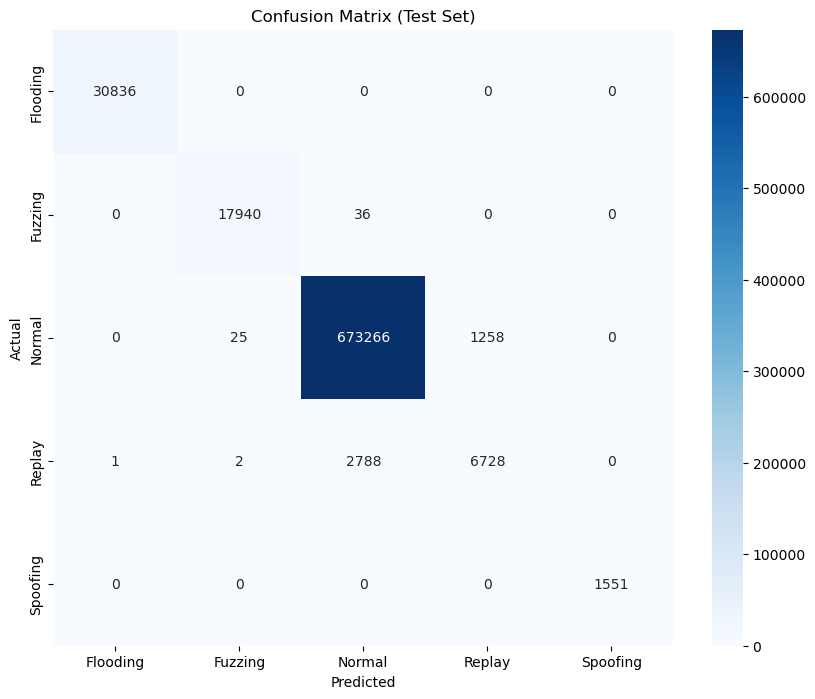

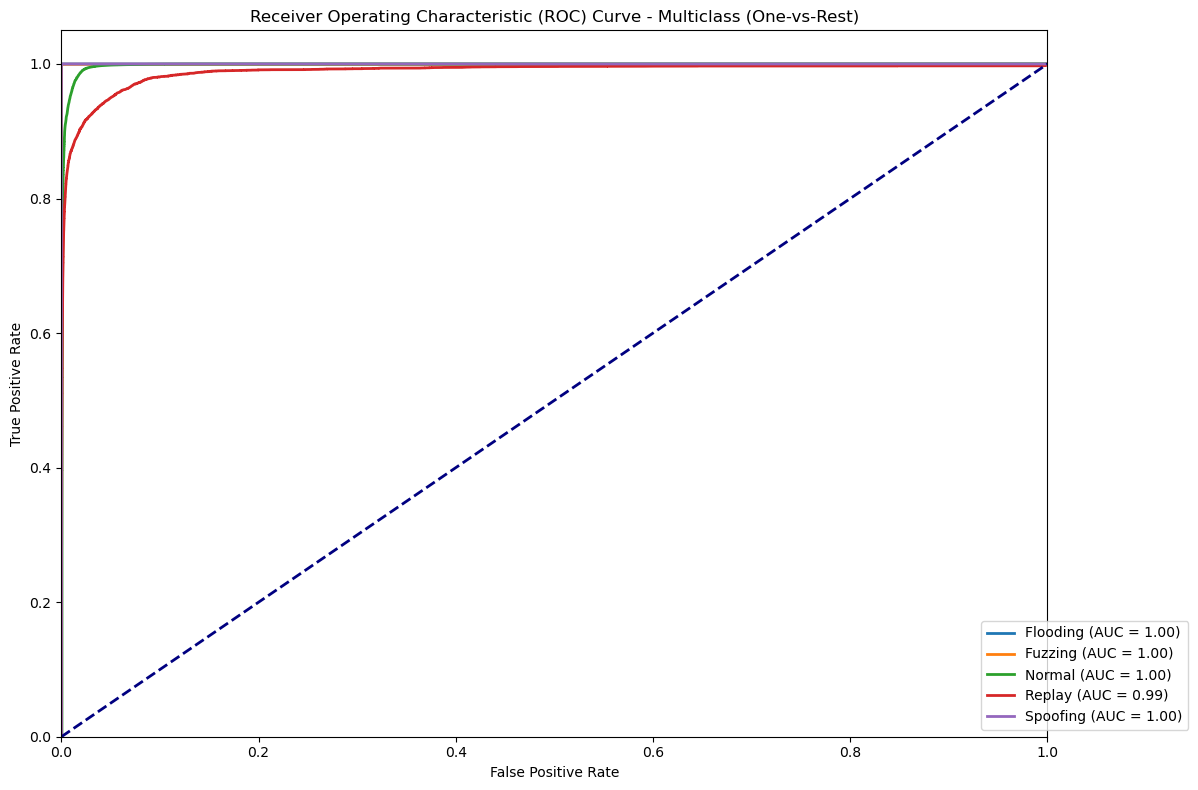


Macro-average ROC AUC: 0.9972


In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the dataset directory
directory = "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training"

# Step 2: Load and merge all CSV files
def load_and_merge_files(dir_path):
    all_dfs = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(dir_path, filename)
            try:
                df = pd.read_csv(file_path)
                df['File'] = filename  # Add file identifier for reference
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    if not all_dfs:
        raise ValueError("No CSV files found or all files failed to load.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

# Step 3: Preprocess the data
def preprocess_data(df):
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')

    # Numerical columns
    num_cols = ['Timestamp', 'DLC']
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

    # Categorical columns
    cat_cols = ['Arbitration_ID', 'Data', 'Class', 'SubClass']
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    # Remove duplicates
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - df.shape[0]} duplicate rows. Shape after: {df.shape}")

    # Parse Data field
    def parse_data(data_str):
        try:
            bytes_list = data_str.strip().split()
            bytes_int = [int(b, 16) if b else 0 for b in bytes_list]
            while len(bytes_int) < 8:
                bytes_int.append(0)
            return bytes_int[:8]
        except:
            return [0] * 8

    data_bytes = df['Data'].apply(parse_data)
    data_bytes_df = pd.DataFrame(data_bytes.tolist(), columns=[f'Byte_{i+1}' for i in range(8)], index=df.index)
    df = pd.concat([df, data_bytes_df], axis=1)
    df.drop('Data', axis=1, inplace=True)

    # Feature engineering: Time differences
    df.sort_values('Timestamp', inplace=True)
    df['Time_Diff'] = df['Timestamp'].diff().fillna(0)

    # Encode categorical features
    le_arb = LabelEncoder()
    df['Arbitration_ID_Encoded'] = le_arb.fit_transform(df['Arbitration_ID'])

    le_label = LabelEncoder()
    df['Label'] = le_label.fit_transform(df['SubClass'])
    class_names = le_label.classes_

    print("\nClass distribution in dataset:")
    class_counts = df['SubClass'].value_counts()
    print(class_counts)

    if any(class_counts < 10):
        print("Warning: Some classes have very low sample counts (<10).")

    df.drop(['Timestamp', 'Arbitration_ID', 'Class', 'SubClass', 'File'], axis=1, errors='ignore', inplace=True)

    return df, class_names, le_label

# Step 4: Train and evaluate the model
def train_model(X, y, class_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    unique_classes_test = np.unique(y_test)
    if len(unique_classes_test) < len(class_names):
        print("Warning: Test set missing classes. Adjusting split...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    total_samples = len(X)
    print(f"\nTraining set shape: {X_train.shape} ({len(X_train)/total_samples*100:.2f}% of total)")
    print(f"Test set shape: {X_test.shape} ({len(X_test)/total_samples*100:.2f}% of total)")

    class_map = {i: class_names[i] for i in range(len(class_names))}
    print("\nTraining set class distribution:")
    print(pd.Series(y_train).map(class_map).value_counts())
    print("\nTest set class distribution:")
    print(pd.Series(y_test).map(class_map).value_counts())

    model = LGBMClassifier(n_estimators=100, random_state=42, objective='multiclass', metric='multi_logloss', num_class=len(class_names))
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    y_prob = model.predict_proba(X_test)

    plt.figure(figsize=(12, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        if len(y_test[y_test == i]) > 0:
            plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass (One-vs-Rest)')
    plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0), ncol=1)
    plt.tight_layout()
    plt.show()

    macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    print(f"\nMacro-average ROC AUC: {macro_auc:.4f}")

    return model

if __name__ == "__main__":
    try:
        print("Loading dataset...")
        df = load_and_merge_files(directory)

        print("\nPreprocessing data...")
        df_processed, class_names, le_label = preprocess_data(df)

        print("\nOverall Class Distribution:")
        class_map = {i: class_names[i] for i in range(len(class_names))}
        print(pd.Series(df_processed['Label']).map(class_map).value_counts())

        X = df_processed.drop('Label', axis=1)
        y = df_processed['Label']

        print("\nTraining model...")
        ids_model = train_model(X, y, class_names)

    except Exception as e:
        print(f"An error occurred: {e}")
